In [1]:
import pandas as pd
import numpy as np
import os
import sys
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [3]:
import plot_help

In [4]:
from importlib import reload

In [5]:
plot_help = reload(plot_help)

# 0. Paths

In [6]:
PATH_TRAINING = os.path.join("..","training")
PATH_OUTPUTS = os.path.join(PATH_TRAINING,"outputs")
PATH_MASTERS = os.path.join(PATH_TRAINING, "data")

In [7]:
# Number of subimgs given one jgp spectrogram
num_subimgs = 3

# 1. Load data

## 1.1 Dictionary of embeddings

In [8]:
filename = "dict_catalan_hard.pickle"

In [9]:
PATH_FILENAME = os.path.join(PATH_OUTPUTS, filename)
with open(PATH_FILENAME, 'rb') as handle:
    dict_pred = pickle.load(handle)

In [10]:
num_artists = len(dict_pred.keys())

## 1.2 Master artist and track

In [11]:
# Master Artist
filename_csv = 'master_artist.csv'
path_csv = os.path.join(PATH_MASTERS, filename_csv)
m_artist = pd.read_csv(path_csv,sep=",")

# Master track
filename_csv = 'master_track.csv'
path_csv = os.path.join(PATH_MASTERS, filename_csv)
m_track = pd.read_csv(path_csv,sep=",")

## 1.3 Dataframe of embeddings

In [12]:
values = []
edgecolors = {'train': "#1A1717", 'test': "#EE3811"} # test: rojo, train: negro

for art in tqdm(dict_pred):
    for tr in dict_pred[art]:
        for jj in range(num_subimgs - 1):
            size = dict_pred[art][tr][jj]["size_point"]
            alpha = edgecolors["train"] if size == 50 else edgecolors["test"]
            l = [art, tr, jj, size, alpha]
            for embed_val in dict_pred[art][tr][jj]["embedding"]:
                l.append(embed_val)
            values.append(l)

In [13]:
# Create the dataframe for T-SNE
df_tsne = pd.DataFrame(values, columns = ["art","img","subimg","size_point","alpha", "embed"])

# Get the track_id from the image file
df_tsne["tr"] = df_tsne['img'].apply(lambda x: x.split("__")[0])

# Get the artist name
df_tsne = pd.merge(df_tsne, m_artist[["artist_id","artist_name"]], 
                   left_on = "art", right_on = "artist_id", how = "left")

# Get the track name
df_tsne = pd.merge(df_tsne, m_track[["track_id","track_name"]], 
                   left_on = "tr", right_on = "track_id", how = "left")

In [14]:
# Put the embeddings into a matrix for t-SNE modelling
vals = []
for ll in df_tsne.embed:
    vals.append(list(ll))
vals_arr = np.array(vals)

# 2. t-SNE

In [15]:
tsne_model = TSNE()
X_2d = tsne_model.fit_transform(vals_arr)

In [16]:
# Get TRUE artists
original_artist = np.array(df_tsne.artist_name)

# Colors
all_colors = ["#800000","#9A6324","#808000","#EFD2CB","#469990",
                "#000075","#000000","#e6194B","#f58231","#ffe119","#bfef45",
                "#3cb44b","#42d4f4","#4363d8","#911eb4","#f032e6","#a9a9a9","#fabed4",
                "#ffd8b1","#fffac8","#aaffc3","#dcbeff","#0B0033","#370031","#832232","#CE8964","#EAF27C"
                ]

colors_extra = all_colors[:num_artists]

# 2. UMAP

In [17]:
#!pip install umap-learn

In [18]:
import umap

In [19]:
reducer = umap.UMAP()

In [20]:
df_umap = reducer.fit_transform(vals_arr)

# 3. Plot embeddings

In [21]:
plot_help = reload(plot_help)

## 3.1 Training

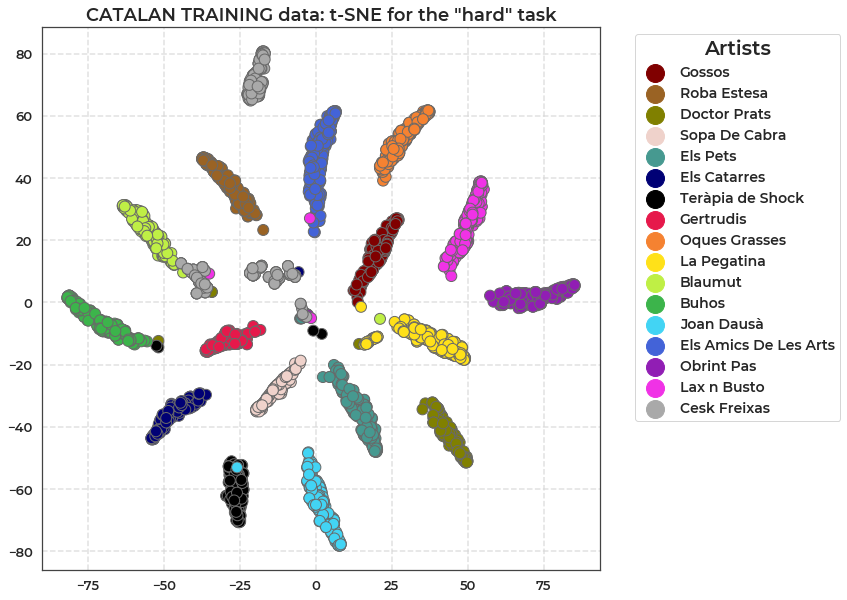

In [23]:
plt.figure(figsize=(10,10))
mask_train = np.array(df_tsne.size_point == 50)
sns.scatterplot(x=X_2d[mask_train, 0], y=X_2d[mask_train, 1], hue=original_artist[mask_train], 
                s= 120, alpha = 1, 
                edgecolors=df_tsne.loc[mask_train, "alpha"], linewidth = 1, edgecolor = "#696969",
                palette=sns.color_palette(colors_extra[:len(set(original_artist[mask_train]))]))
plt.title('CATALAN TRAINING data: t-SNE for the "hard" task', fontsize = 18)
lgnd = plt.legend(title="Artists", bbox_to_anchor=(1.05, 1), loc='upper left', markerscale = 3)
plt.savefig("CAT_DIFF/CAT_DIFF_TRAIN_TSNE.jpg", bbox_inches='tight')

#### UMAP

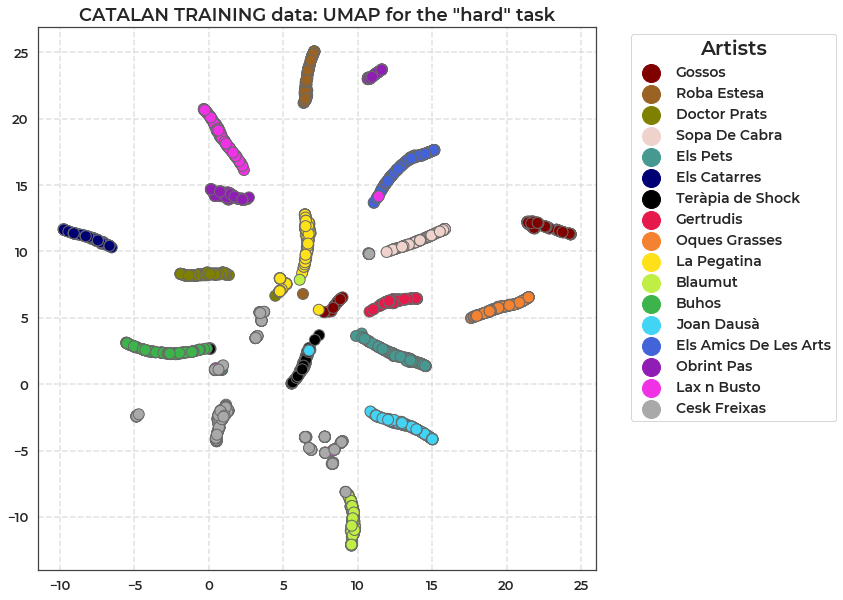

In [24]:
plt.figure(figsize=(10,10))
mask_train = np.array(df_tsne.size_point == 50)
sns.scatterplot(x=df_umap[mask_train, 0], y=df_umap[mask_train, 1], hue=original_artist[mask_train], 
                s= 120, alpha = 1, 
                edgecolors=df_tsne.loc[mask_train, "alpha"], linewidth = 1, edgecolor = "#696969",
                palette=sns.color_palette(colors_extra[:len(set(original_artist[mask_train]))]))
plt.title('CATALAN TRAINING data: UMAP for the "hard" task', fontsize = 18)
lgnd = plt.legend(title="Artists", bbox_to_anchor=(1.05, 1), loc='upper left', markerscale = 3)
plt.savefig("CAT_DIFF/CAT_DIFF_TRAIN_UMAP.jpg", bbox_inches='tight')

## 3.2 Testing

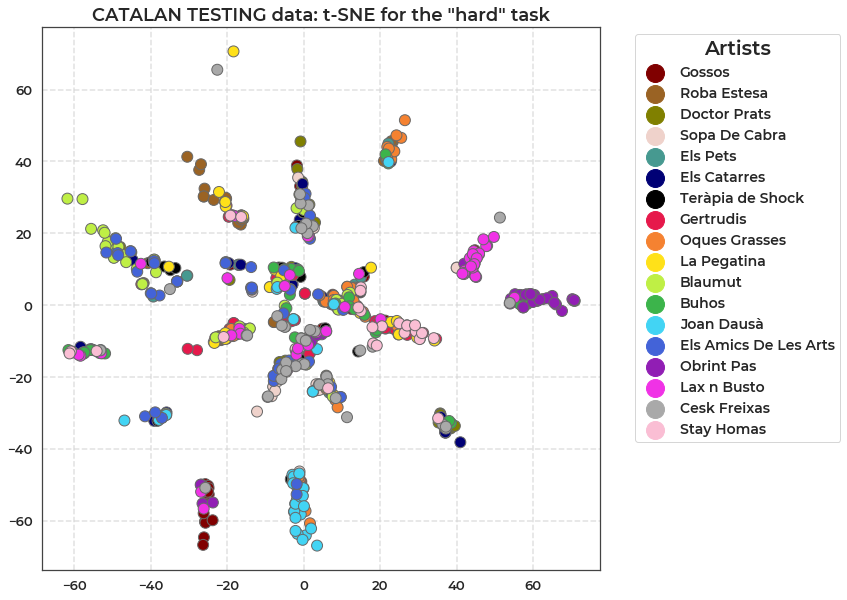

In [25]:
plt.figure(figsize=(10,10))
mask_train = np.array(df_tsne.size_point == 200)
sns.scatterplot(x=X_2d[mask_train, 0], y=X_2d[mask_train, 1], hue=original_artist[mask_train], 
                s= 120, alpha = 1, 
                edgecolors=df_tsne.loc[mask_train, "alpha"], linewidth = 1, edgecolor = "#696969",
                palette=sns.color_palette(colors_extra[:len(set(original_artist[mask_train]))]))
plt.title('CATALAN TESTING data: t-SNE for the "hard" task', fontsize = 18)
plt.legend(title="Artists", bbox_to_anchor=(1.05, 1), loc='upper left', markerscale = 3)
plt.savefig("CAT_DIFF/CAT_DIFF_TEST_TSNE.jpg", bbox_inches='tight')

#### UMAP

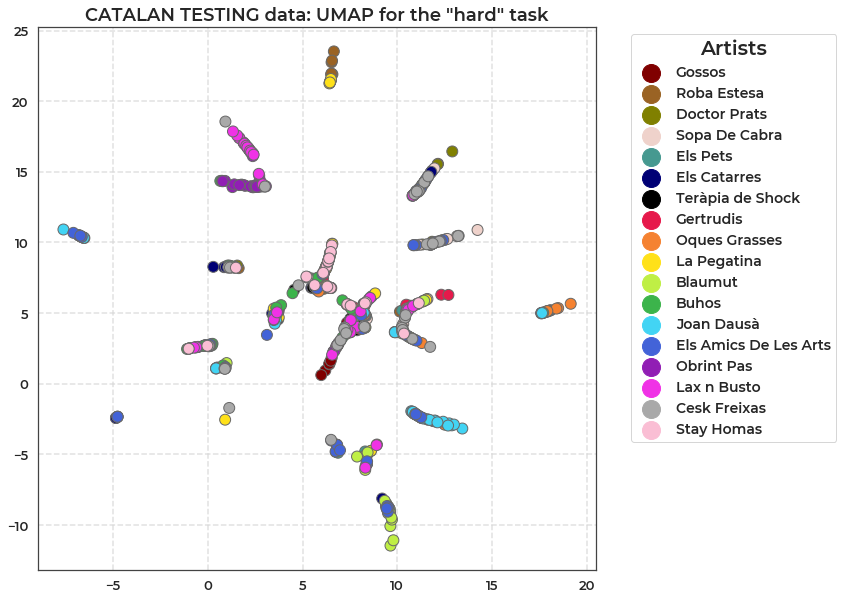

In [26]:
plt.figure(figsize=(10,10))
mask_train = np.array(df_tsne.size_point == 200)
sns.scatterplot(x=df_umap[mask_train, 0], y=df_umap[mask_train, 1], hue=original_artist[mask_train], 
                s= 120, alpha = 1, 
                edgecolors=df_tsne.loc[mask_train, "alpha"],linewidth = 1, edgecolor = "#696969",
                palette=sns.color_palette(colors_extra[:len(set(original_artist[mask_train]))]))
plt.title('CATALAN TESTING data: UMAP for the "hard" task', fontsize = 18)
plt.legend(title="Artists", bbox_to_anchor=(1.05, 1), loc='upper left', markerscale = 3)
plt.savefig("CAT_DIFF/CAT_DIFF_TEST_UMAP.jpg", bbox_inches='tight')

## 3.3 Train and Test

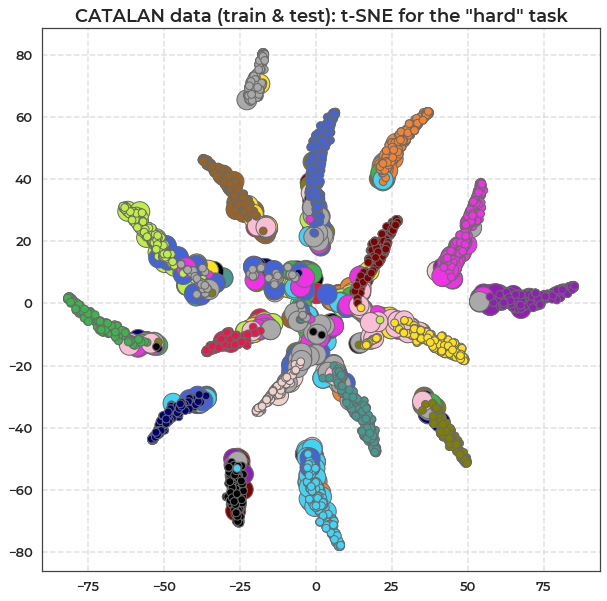

In [27]:
plt.figure(figsize=(10,10))

# Test
mask_train = np.array(df_tsne.size_point == 200)
sns.scatterplot(x=X_2d[mask_train, 0], y=X_2d[mask_train, 1], hue=original_artist[mask_train], 
                s= 400, alpha = 1, 
                edgecolors=df_tsne.loc[mask_train, "alpha"], linewidth = 1, edgecolor = "#696969",
                palette=sns.color_palette(colors_extra[:len(set(original_artist[mask_train]))]))
plt.title('CATALAN data (train & test): t-SNE for the "hard" task', fontsize = 18)#leg = plt.legend(title="Artists", bbox_to_anchor=(1.05, 1), loc='upper left')
#Train
mask_train = np.array(df_tsne.size_point == 50)
sns.scatterplot(x=X_2d[mask_train, 0], y=X_2d[mask_train, 1], hue=original_artist[mask_train], 
                s= 60, alpha = 1, 
                edgecolors=df_tsne.loc[mask_train, "alpha"], linewidth = 1, edgecolor = "#696969",
                palette=sns.color_palette(colors_extra[:len(set(original_artist[mask_train]))]))

plt.legend([],[], frameon=False)
plt.savefig("CAT_DIFF/CAT_DIFF_TRAINTEST_TSNE.jpg", bbox_inches='tight')

#### UMAP

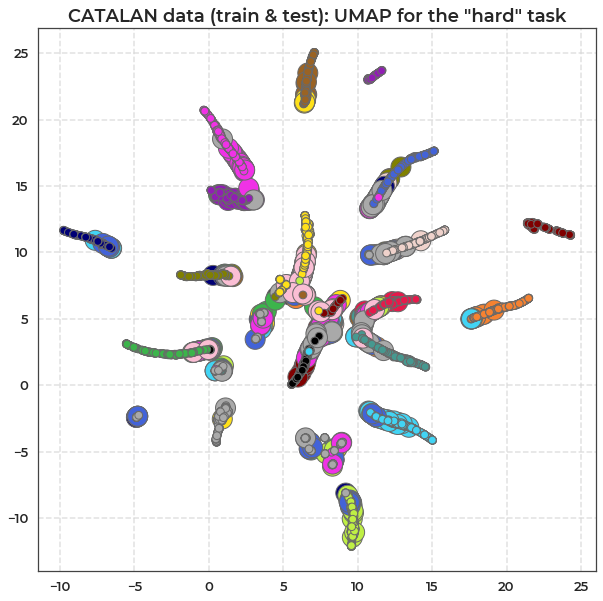

In [28]:
plt.figure(figsize=(10,10))

# Test
mask_train = np.array(df_tsne.size_point == 200)
sns.scatterplot(x=df_umap[mask_train, 0], y=df_umap[mask_train, 1], hue=original_artist[mask_train], 
                s= 400, alpha = 1, 
                edgecolors=df_tsne.loc[mask_train, "alpha"], linewidth = 1, edgecolor = "#696969",
                palette=sns.color_palette(colors_extra[:len(set(original_artist[mask_train]))]))
plt.title('CATALAN data (train & test): UMAP for the "hard" task', fontsize = 18)#leg = plt.legend(title="Artists", bbox_to_anchor=(1.05, 1), loc='upper left')
#Train
mask_train = np.array(df_tsne.size_point == 50)
sns.scatterplot(x=df_umap[mask_train, 0], y=df_umap[mask_train, 1], hue=original_artist[mask_train], 
                s= 60, alpha = 1, 
                edgecolors=df_tsne.loc[mask_train, "alpha"], linewidth = 1, edgecolor = "#696969",
                palette=sns.color_palette(colors_extra[:len(set(original_artist[mask_train]))]))

plt.legend([],[], frameon=False)
plt.savefig("CAT_DIFF/CAT_DIFF_TRAINTEST_UMAP.jpg", bbox_inches='tight')

## 3.4 Examining One Artist

### Joan Dausa

In [45]:
# Filter
art = "Joan Dausà"
mask_art = np.array((df_tsne.artist_name == art))
df_tsne_art = df_tsne.loc[mask_art]

# Legend values
original_track = df_tsne_art.track_name
num_tracks = len(original_track.unique())

(-40.0, -80.0)

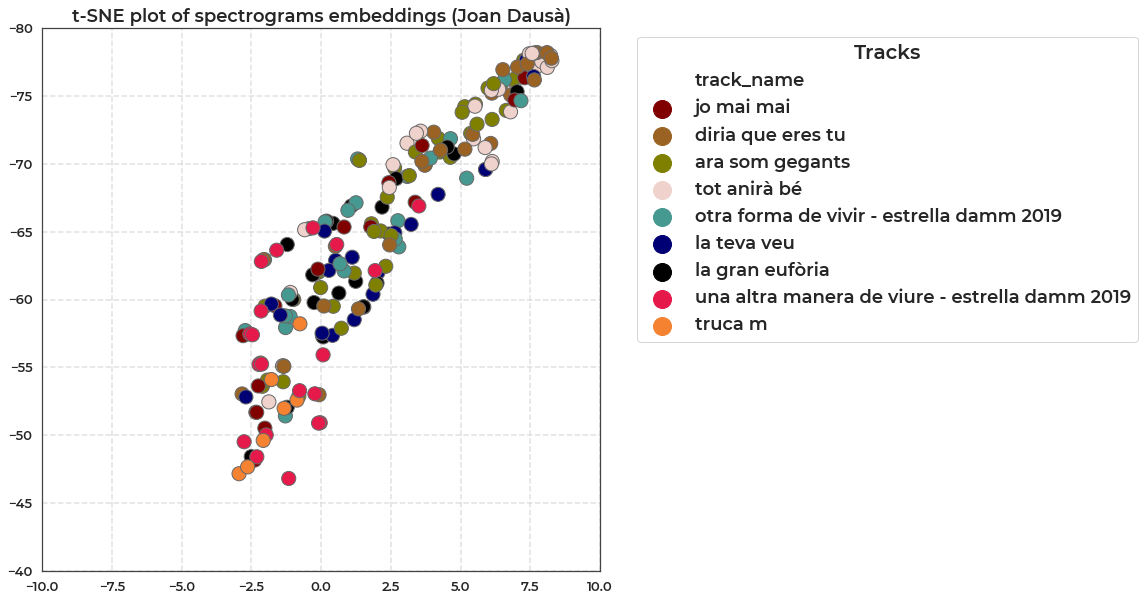

In [46]:
plt.figure(figsize=(10,10))
mask_train = np.array(df_tsne_art.size_point == 50)
sns.scatterplot(x=X_2d[mask_art, 0], y=X_2d[mask_art, 1], hue=original_track, 
                alpha = 1, linewidth = 1, edgecolor = "#696969",s = 200,
               palette=sns.color_palette(colors_extra[:num_tracks]))
plt.title(f't-SNE plot of spectrograms embeddings ({art})', fontsize = 18)
lgnd = plt.legend(title="Tracks", bbox_to_anchor=(1.05, 1), loc='upper left', markerscale = 3, fontsize = 18)

plt.xlim(-10,10)
plt.ylim(-40,-80)

#### UMAP

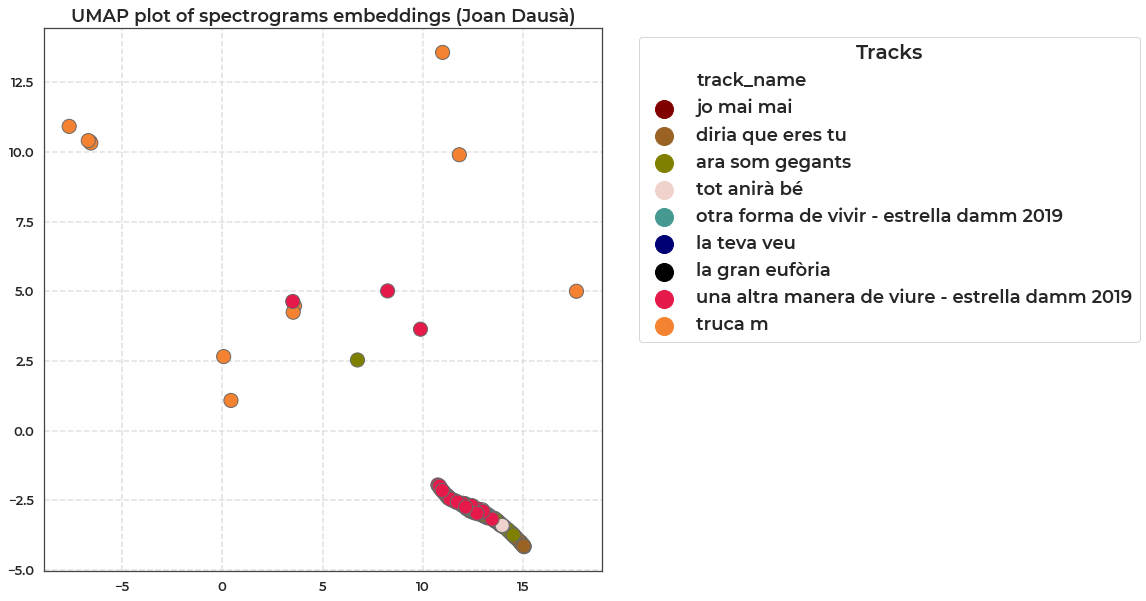

In [34]:
plt.figure(figsize=(10,10))
mask_train = np.array(df_tsne_art.size_point == 50)
sns.scatterplot(x=df_umap[mask_art, 0], y=df_umap[mask_art, 1], hue=original_track, 
                alpha = 1, linewidth = 1, edgecolor = "#696969",s = 200,
               palette=sns.color_palette(colors_extra[:num_tracks]))
plt.title(f'UMAP plot of spectrograms embeddings ({art})', fontsize = 18)
lgnd = plt.legend(title="Tracks", bbox_to_anchor=(1.05, 1), loc='upper left', markerscale = 3, fontsize = 18)

#plt.xlim(1,7)
#plt.ylim(6,9)

###  Buhos

In [98]:
# Filter
art = "Buhos"
mask_art = np.array((df_tsne.artist_name == art))
df_tsne_art = df_tsne.loc[mask_art]

# Legend values
original_track = df_tsne_art.track_name
num_tracks = len(original_track.unique())

(-20.0, -60.0)

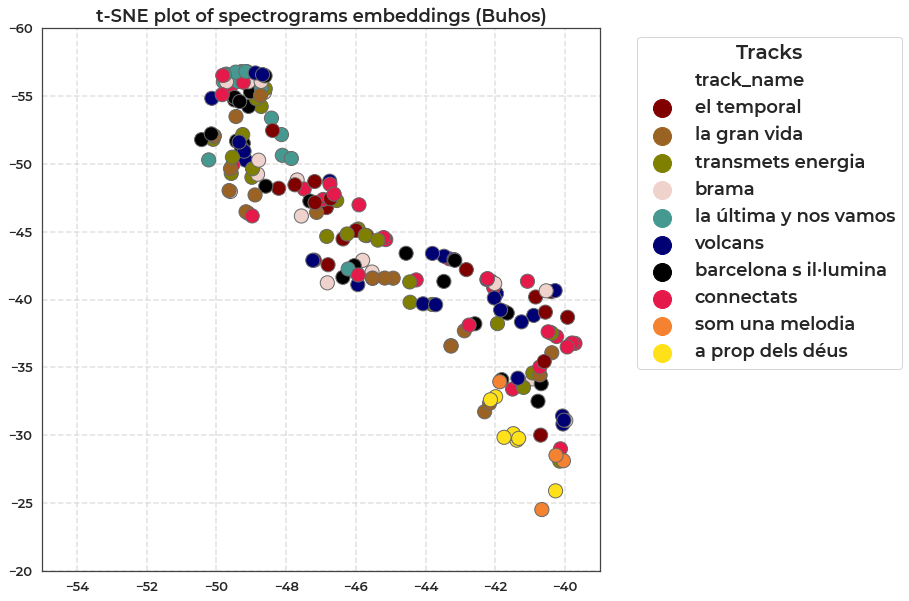

In [99]:
plt.figure(figsize=(10,10))
mask_train = np.array(df_tsne_art.size_point == 50)
sns.scatterplot(x=X_2d[mask_art, 0], y=X_2d[mask_art, 1], hue=original_track, 
                alpha = 1, linewidth = 1, edgecolor = "#696969",s = 200,
               palette=sns.color_palette(colors_extra[:num_tracks]))
plt.title(f't-SNE plot of spectrograms embeddings ({art})', fontsize = 18)
lgnd = plt.legend(title="Tracks", bbox_to_anchor=(1.05, 1), loc='upper left', markerscale = 3, fontsize = 18)

plt.xlim(-55,-39)
plt.ylim(-20,-60)

# 4. Performances of Neural Network

In [101]:
values = []
cols = []

for art in tqdm(dict_pred):
    for tr in dict_pred[art]:
        for jj in range(num_subimgs - 1):
            true_pred = dict_pred[art][tr][jj]["true_pred"]
            position_label_real = dict_pred[art][tr][jj]["position_label_real"]
            position_label_pred = dict_pred[art][tr][jj]["position_label_pred"]
            label_real = dict_pred[art][tr][jj]["label_real"]
            predictions = list(np.round(dict_pred[art][tr][jj]["predictions"].ravel(),2))
            is_train = dict_pred[art][tr][jj]["is_train"]
            l = [art, tr, true_pred, position_label_real, position_label_pred, label_real, 
                predictions, is_train]
            values.append(l)
cols = ["art","img", "true_pred", "pos_real", "pos_pred", "real", "pred", "is_train"]
df_perf = pd.DataFrame(values, columns = cols )

## Bring the artist name and track name

In [102]:
# Get the track_id from the image file
df_perf["tr"] = df_perf['img'].apply(lambda x: x.split("__")[0])

# Get the artist name
df_perf = pd.merge(df_perf, m_artist[["artist_id","artist_name"]], 
                   left_on = "art", right_on = "artist_id", how = "left")

# Get the track name
df_perf = pd.merge(df_perf, m_track[["track_id","track_name"]], 
                   left_on = "tr", right_on = "track_id", how = "left")

# Remove duplicated columns
df_perf.drop(["artist_id","track_id"], axis = 1, inplace = True)

## 4.2 Confusion Matrix

In [103]:
# Artist labels
sort_artists = np.sort(df_perf["artist_name"].unique())

dict_art_lab = dict()

for ii, row in df_perf.iterrows():
    
    if row["artist_name"] not in dict_art_lab:
        
        # Insert the position of the 1 in the vector
        dict_art_lab[row["artist_name"]] = row["pos_real"]

### All

In [104]:
# Manually create the confusion matrix
mat = []

for art_real in sort_artists:
    art_list = []
    for art_pred in sort_artists:
        
        # Position real
        pos_real = dict_art_lab[art_real]
        
        # Pred artist, get the position of the label
        pos_pred = dict_art_lab[art_pred]
        
        # Mask real  
        mask_art_real = df_perf["pos_real"] == pos_real
        mask_art_pred = df_perf["pos_pred"] == pos_pred
        
        # Df masked
        df_masked = df_perf[mask_art_real & mask_art_pred]
        nums = df_masked.shape[0]
        art_list.append(nums)
    mat.append(art_list)
    
# Set it as a pandas dataframe
df_mat = pd.DataFrame(np.array(mat), columns = sort_artists, index = sort_artists)

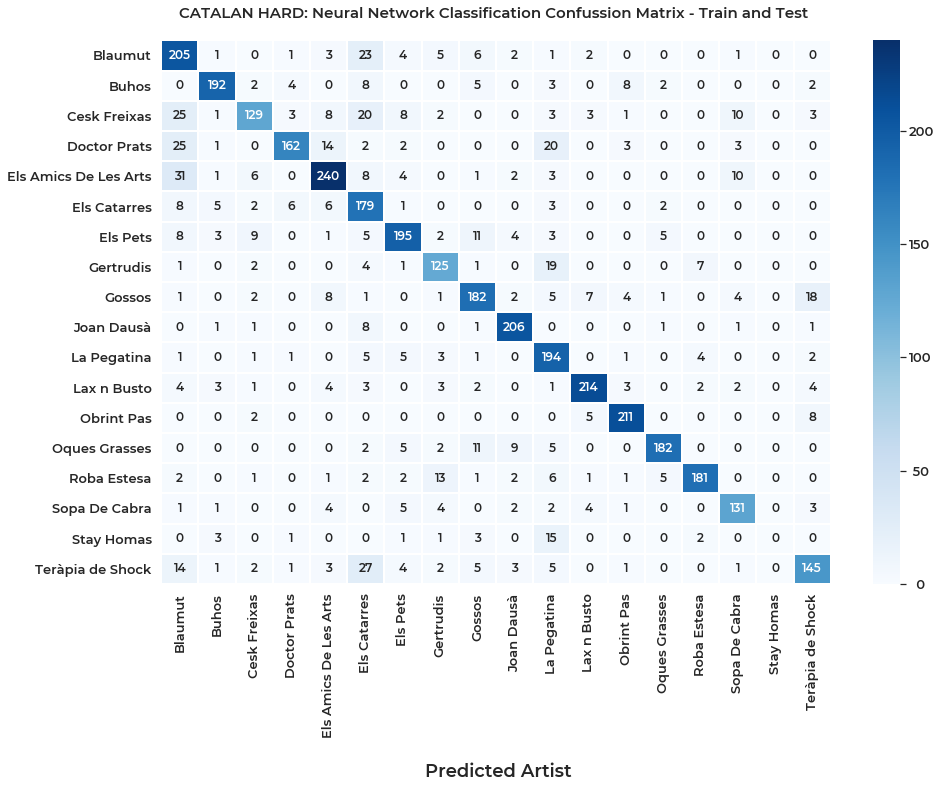

In [105]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(15, 10))
plt.title("CATALAN HARD: Neural Network Classification Confussion Matrix - Train and Test \n")
axh = sns.heatmap(df_mat, annot=True, fmt=".3g", linewidths=1.2, ax=ax, cmap="Blues",
                  cbar_kws={'format': '%3d'}, annot_kws={"size": 12})
plt.xlabel("\n Predicted Artist", fontsize = 18);
plt.savefig("CAT_DIFF/NN_CAT_HARD_TRAINTEST.jpg", bbox_inches='tight')

### Test

In [106]:
# Manually create the confusion matrix
mat_test = []

for art_real in sort_artists:
    art_list = []
    for art_pred in sort_artists:
        
        # Position real
        pos_real = dict_art_lab[art_real]
        
        # Pred artist, get the position of the label
        pos_pred = dict_art_lab[art_pred]
        
        # Mask real  
        mask_art_real = df_perf["pos_real"] == pos_real
        mask_art_pred = df_perf["pos_pred"] == pos_pred
        # Mask test
        mask_test = df_perf["is_train"] == 0
        
        # Df masked
        df_masked = df_perf[mask_art_real & mask_art_pred & mask_test]
        nums = df_masked.shape[0]
        art_list.append(nums)
    mat_test.append(art_list)
    
# Set it as a pandas dataframe
df_mat_test = pd.DataFrame(np.array(mat_test), columns = sort_artists, index = sort_artists)

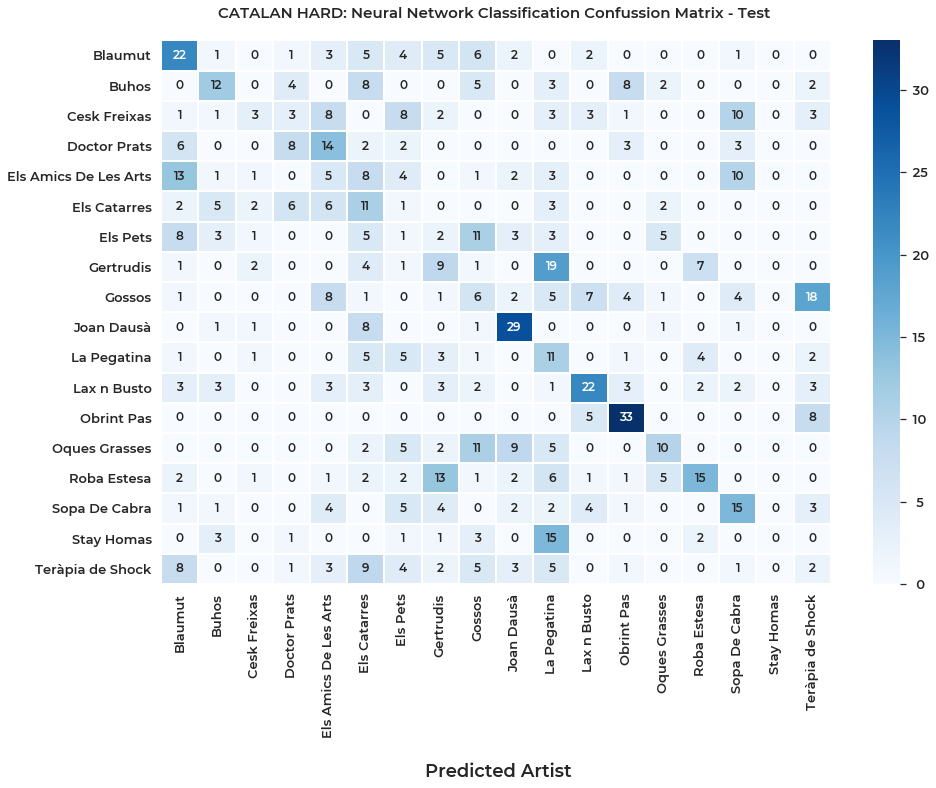

In [107]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(15, 10))
plt.title("CATALAN HARD: Neural Network Classification Confussion Matrix - Test \n")
axh = sns.heatmap(df_mat_test, annot=True, fmt=".3g", linewidths=1.2, ax=ax, cmap="Blues",
                  cbar_kws={'format': '%3d'}, annot_kws={"size": 12})
plt.xlabel("\n Predicted Artist", fontsize = 18);
plt.savefig("CAT_DIFF/NN_CAT_HARD_TEST.jpg", bbox_inches='tight')

### Train

In [108]:
# Manually create the confusion matrix
mat_train = []

for art_real in sort_artists:
    art_list = []
    for art_pred in sort_artists:
        
        # Position real
        pos_real = dict_art_lab[art_real]
        
        # Pred artist, get the position of the label
        pos_pred = dict_art_lab[art_pred]
        
        # Mask real  
        mask_art_real = df_perf["pos_real"] == pos_real
        mask_art_pred = df_perf["pos_pred"] == pos_pred
        # Mask train
        mask_train = df_perf["is_train"] == 1
        
        # Df masked
        df_masked = df_perf[mask_art_real & mask_art_pred & mask_train]
        nums = df_masked.shape[0]
        art_list.append(nums)
    mat_train.append(art_list)
    
# Set it as a pandas dataframe
df_mat_train= pd.DataFrame(np.array(mat_train), columns = sort_artists, index = sort_artists)

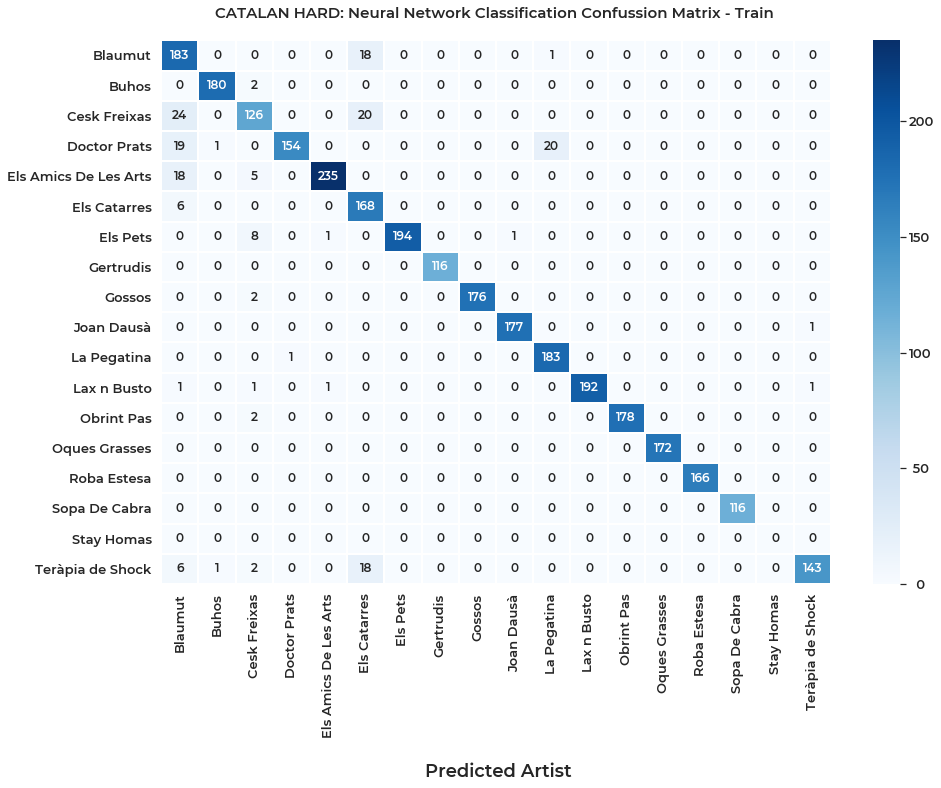

In [109]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(15, 10))
plt.title("CATALAN HARD: Neural Network Classification Confussion Matrix - Train \n")
axh = sns.heatmap(df_mat_train, annot=True, fmt=".3g", linewidths=1.2, ax=ax, cmap="Blues",
                  cbar_kws={'format': '%3d'}, annot_kws={"size": 12})
plt.xlabel("\n Predicted Artist", fontsize = 18);
plt.savefig("CAT_DIFF/NN_CAT_HARD_TRAIN.jpg", bbox_inches='tight')

## 4.3 Accuracy

In [96]:
acc_list = list()

# TOTAL
for ii_art in df_mat.index:
    idx_max_cluster = df_mat.loc[ii_art].argmax()
    CORRECT = df_mat.loc[ii_art][idx_max_cluster]
    TOTAL = df_mat.loc[ii_art].sum()
    acc = np.round(CORRECT / TOTAL,3)
    acc_list.append(acc)
    
df_acc_artists = pd.DataFrame(acc_list, index = df_mat.index, columns = ["accuracy"])

# TRAIN
acc_list_train = list()

for art in df_mat_train.index:
    CORRECT = df_mat_train.loc[art][art]
    TOTAL = df_mat_train.loc[art].sum()
    acc = np.round(CORRECT / TOTAL,3)
    acc_list_train.append(acc)
    
# TEST
acc_list_test = list()

for art in df_mat_test.index:
    CORRECT = df_mat_test.loc[art][art]
    TOTAL = df_mat_test.loc[art].sum()
    acc = np.round(CORRECT / TOTAL,3)
    acc_list_test.append(acc)
    
df_acc_artists_train = pd.DataFrame(acc_list_train, index = df_mat_train.index, columns = ["accuracy_train"])
df_acc_artists_test = pd.DataFrame(acc_list_test, index = df_mat_test.index, columns = ["accuracy_test"])

df_acc_final = pd.merge(df_acc_artists_train, df_acc_artists_test, left_index=True, right_index=True)
df_acc_final = pd.merge(df_acc_final, df_acc_artists, left_index=True, right_index=True)
df_acc_final.sort_values("accuracy_test", ascending = False, inplace = True)
df_acc_final.to_latex("NN_CATALAN_HARD_ACCURACY.tex")
df_acc_final

/Users/david/.local/share/virtualenvs/Spotify-xJiBt4R8/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars


,accuracy_train,accuracy_test,accuracy
Obrint Pas,0.989,0.717,0.934
Joan Dausà,0.994,0.690,0.936
Lax n Busto,0.980,0.440,0.870
Blaumut,0.906,0.423,0.807
Sopa De Cabra,1.000,0.357,0.829
La Pegatina,0.995,0.324,0.890
Els Catarres,0.966,0.289,0.844
Roba Estesa,1.000,0.288,0.830
Buhos,0.989,0.273,0.850
Oques Grasses,1.000,0.227,0.843


In [97]:
df_acc_final["accuracy_train"].mean()

0.9438823529411764

In [98]:
df_acc_final["accuracy_test"].mean()

0.2658333333333333

# 5. K-Means

In [60]:
from sklearn.cluster import KMeans
from sklearn.metrics import multilabel_confusion_matrix

In [61]:
# Reduced dimensionality
df_kmeans = df_tsne.copy()
df_kmeans["umap1"] = df_umap[:,0]
df_kmeans["umap2"] = df_umap[:,1]
df_kmeans["tsne1"] = X_2d[:,0]
df_kmeans["tsne2"] = X_2d[:,1]

# X data
X_kmeans = df_kmeans[["umap1","umap2"]]

# KMeans
kmeans = KMeans(n_clusters=num_artists, random_state=0).fit(X_kmeans)

# Get the predicted cluster
df_kmeans["pred_umap"] = kmeans.labels_

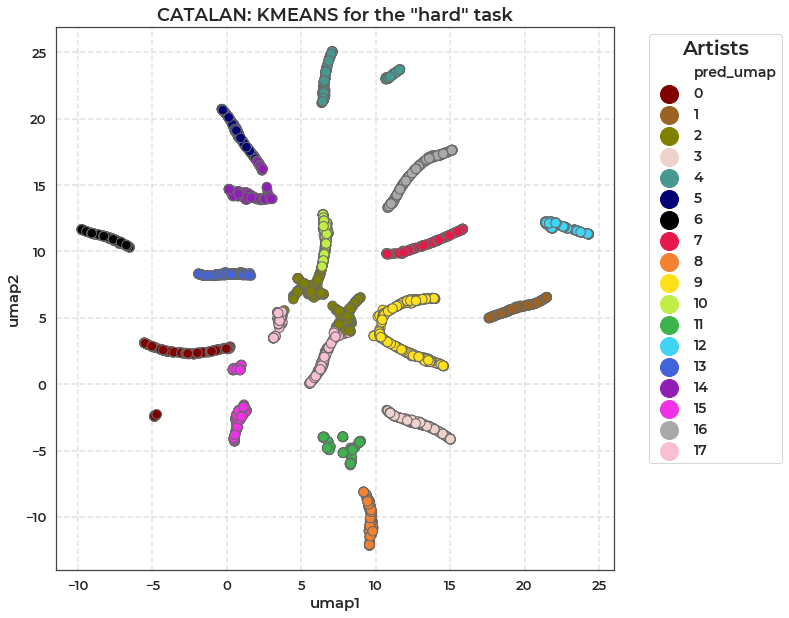

In [62]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=df_kmeans["umap1"], y=df_kmeans["umap2"], hue=df_kmeans["pred_umap"], 
                s= 90, alpha = 1, linewidth = 1, edgecolor = "#696969",
                palette=sns.color_palette(colors_extra[:len(set(df_kmeans["pred_umap"]))]))
plt.title('CATALAN: KMEANS for the "hard" task', fontsize = 18)
plt.legend(title="Artists", bbox_to_anchor=(1.05, 1), loc='upper left', markerscale = 3)
plt.savefig("CAT_DIFF/KMEANS_CAT_DIFF_UMAP.jpg", bbox_inches='tight')

## 4.1 Confusion Matrix for artist classification

In [58]:
# Cluster labels
sort_labels = np.sort(df_kmeans["pred_umap"].unique())

# Artist labels
sort_artists = np.sort(df_kmeans["artist_name"].unique())

# Manually create the confusion matrix
mat = []

for art in sort_artists:
    art_list = []
    for lab in sort_labels:
        mask_art = df_kmeans["artist_name"] == art
        mask_lab = df_kmeans["pred_umap"] == lab
        df_kmeans_filt = df_kmeans[mask_art & mask_lab]
        nums = df_kmeans_filt.shape[0]
        art_list.append(nums)
    mat.append(art_list)
    
# Set it as a pandas dataframe
df_mat = pd.DataFrame(np.array(mat), columns = sort_labels, index = sort_artists)

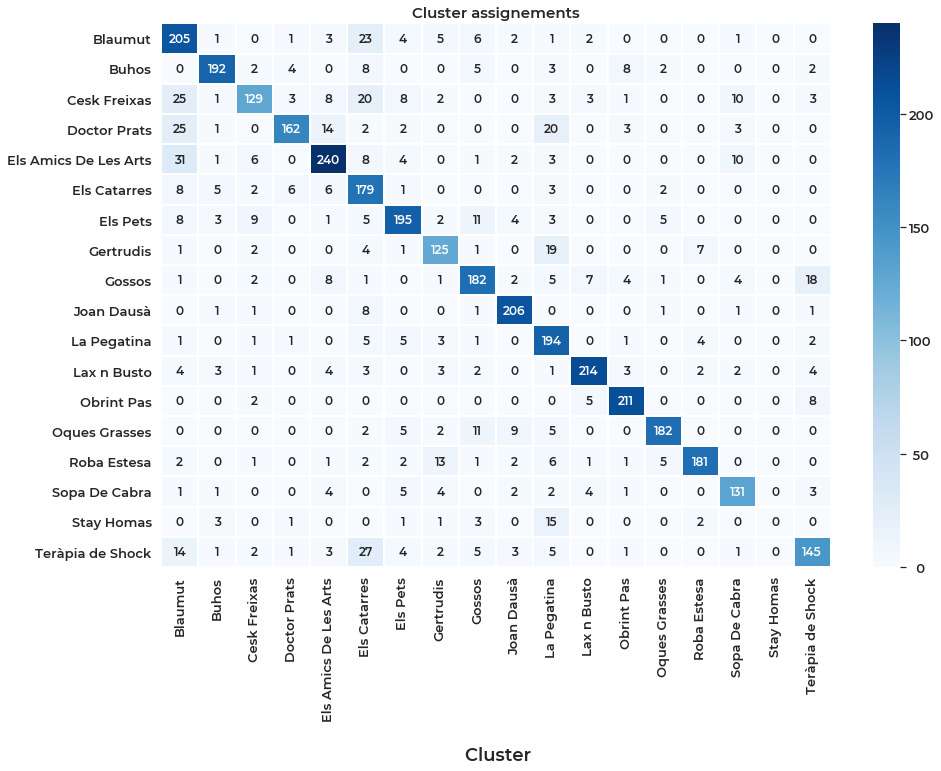

In [66]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(15, 10))
plt.title("Cluster assignements")
axh = sns.heatmap(df_mat, annot=True, fmt=".3g", linewidths=1.2, ax=ax, cmap="Blues",
                  cbar_kws={'format': '%3d'}, annot_kws={"size": 12})
plt.xlabel("\n Cluster", fontsize = 18)
plt.savefig("CAT_DIFF/KMEANS_CAT_HARD_ALL_CONF.jpg", bbox_inches='tight')

### Test

In [64]:
# Cluster labels
sort_labels = np.sort(df_kmeans["pred_umap"].unique())

# Artist labels
sort_artists = np.sort(df_kmeans["artist_name"].unique())

# Manually create the confusion matrix
mat = []

for art in sort_artists:
    art_list = []
    for lab in sort_labels:
        mask_art = df_kmeans["artist_name"] == art
        mask_lab = df_kmeans["pred_umap"] == lab
        mask_test = df_kmeans["size_point"] == 200
        df_kmeans_filt = df_kmeans[mask_art & mask_lab & mask_test]
        nums = df_kmeans_filt.shape[0]
        art_list.append(nums)
    mat.append(art_list)
    
# Set it as a pandas dataframe
df_mat_test = pd.DataFrame(np.array(mat), columns = sort_labels, index = sort_artists)

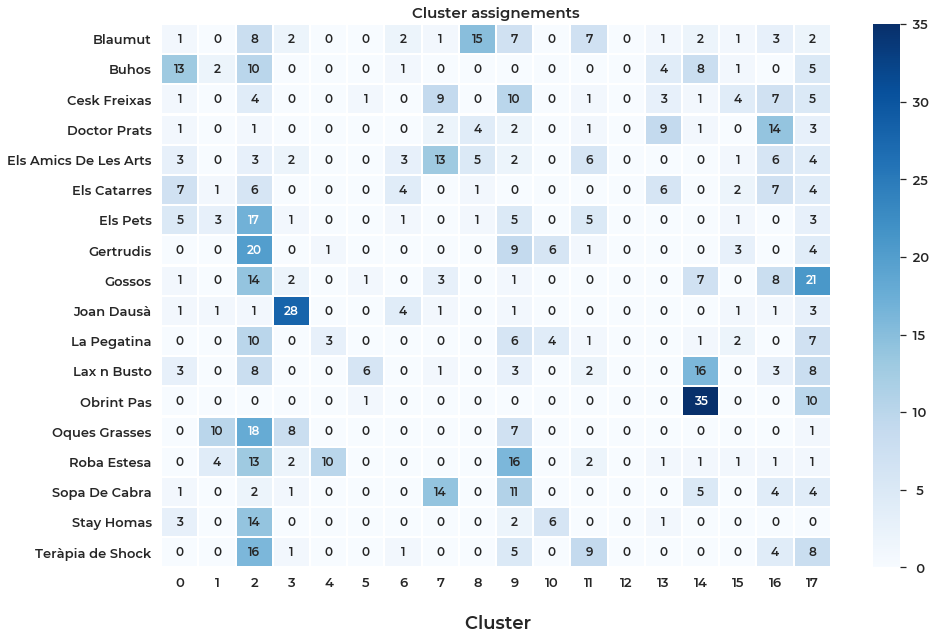

In [67]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(15, 10))
plt.title("Cluster assignements")
axh = sns.heatmap(df_mat_test, annot=True, fmt=".3g", linewidths=1.2, ax=ax, cmap="Blues",
                  cbar_kws={'format': '%3d'}, annot_kws={"size": 12})
plt.xlabel("\n Cluster", fontsize = 18)
plt.savefig("CAT_DIFF/KMEANS_CAT_HARD_TEST_CONF.jpg", bbox_inches='tight')

## 4.2 Confusion matrix for artist tracks misclassification

In [60]:
# Filter
artist_name_query = "Buhos"
mask_art = np.array((df_kmeans.artist_name == artist_name_query))
df_cm_art = df_kmeans.loc[mask_art]

In [61]:
# Cluster labels
sort_labels = np.sort(df_cm_art["pred_umap"].unique())

# Track labels
sort_tracks = np.sort(df_cm_art["track_name"].unique())

In [62]:
# Manually create the confusion matrix
mat = []

for art in sort_tracks:
    art_list = []
    for lab in sort_labels:
        mask_art = df_cm_art["track_name"] == art
        mask_lab = df_cm_art["pred_umap"] == lab
        df_kmeans_filt = df_cm_art[mask_art & mask_lab]
        nums = df_kmeans_filt.shape[0]
        art_list.append(nums)
    mat.append(art_list)
    
# Set it as a pandas dataframe
df_mat_track = pd.DataFrame(np.array(mat), columns = sort_labels, index = sort_tracks)

Text(0.5, 63.5, '\n Cluster')

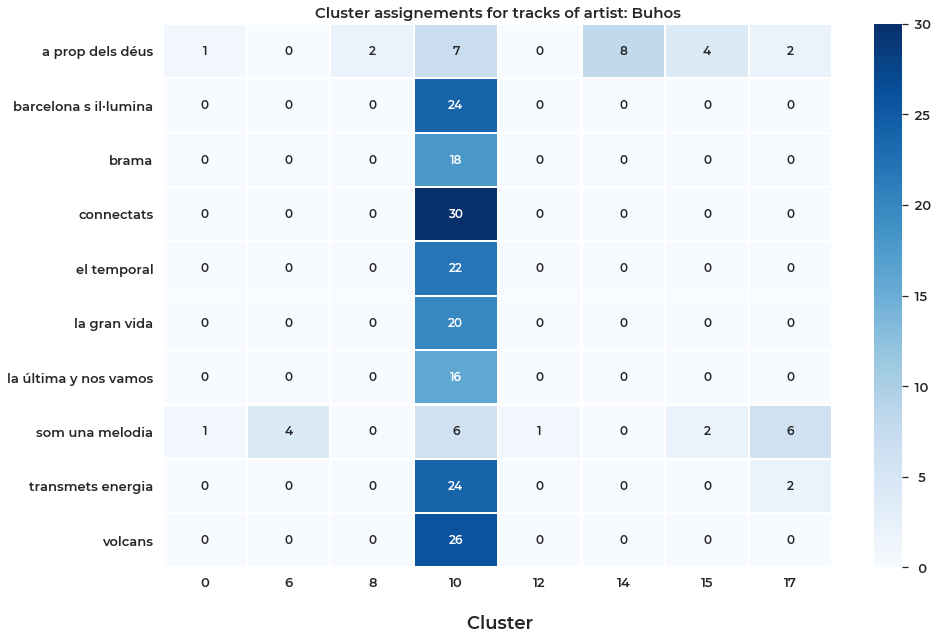

In [63]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(15, 10))
plt.title(f"Cluster assignements for tracks of artist: {artist_name_query}")
axh = sns.heatmap(df_mat_track, annot=True, fmt=".3g", linewidths=1.2, ax=ax, cmap="Blues",
                  cbar_kws={'format': '%3d'}, annot_kws={"size": 12})
plt.xlabel("\n Cluster", fontsize = 18)

#### Pinpoint which is the part of the song that it's miss classified

In [66]:
cluster_mistaken = 17
track_mistake = "som una melodia"
mask_track_mist = df_cm_art["track_name"] == track_mistake
mask_cluster_mistake = df_cm_art["pred_umap"] == cluster_mistaken
df_cm_art[mask_track_mist & mask_cluster_mistake][["img", "subimg"]]

,img,subimg
2547,5tY7OeRxNvFhxFWRtL66DQ__1__20__50.jpg,1
2569,5tY7OeRxNvFhxFWRtL66DQ__9__161__191.jpg,1
2570,5tY7OeRxNvFhxFWRtL66DQ__5__100__130.jpg,0
2573,5tY7OeRxNvFhxFWRtL66DQ__7__140__170.jpg,1
2588,5tY7OeRxNvFhxFWRtL66DQ__6__120__150.jpg,0
2589,5tY7OeRxNvFhxFWRtL66DQ__6__120__150.jpg,1


## 4.3 Accuracy by artist

In [75]:
acc_list = list()

for ii_art in df_mat.index:
    idx_max_cluster = df_mat.loc[ii_art].argmax()
    CORRECT = df_mat.loc[ii_art][idx_max_cluster]
    TOTAL = df_mat.loc[ii_art].sum()
    acc = np.round(CORRECT / TOTAL,3)
    acc_list.append(acc)
    
df_acc_artists = pd.DataFrame(acc_list, index = df_mat.index, columns = ["accuracy"])

In [76]:
df_acc_artists.sort_values("accuracy", ascending = False)

,accuracy
Joan Dausà,0.936
Obrint Pas,0.934
La Pegatina,0.890
Lax n Busto,0.870
Buhos,0.850
Els Catarres,0.844
Oques Grasses,0.843
Roba Estesa,0.830
Sopa De Cabra,0.829
Blaumut,0.807


### Accuracy by training / testing

In [77]:
# Cluster labels
sort_labels = np.sort(df_kmeans["pred_umap"].unique())

# Artist labels
sort_artists = np.sort(df_kmeans["artist_name"].unique())

# Manually create the confusion matrix
mat = []

# TRAIN
for art in sort_artists:
    art_list = []
    for lab in sort_labels:
        mask_art = df_kmeans["artist_name"] == art
        mask_lab = df_kmeans["pred_umap"] == lab
        mask_train = df_kmeans["size_point"] == 50
        df_kmeans_filt = df_kmeans[mask_art & mask_lab & mask_train]
        nums = df_kmeans_filt.shape[0]
        art_list.append(nums)
    mat.append(art_list)
    
# Set it as a pandas dataframe
df_mat_train = pd.DataFrame(np.array(mat), columns = sort_labels, index = sort_artists)

# TEST
mat = []

# TRAIN
for art in sort_artists:
    art_list = []
    for lab in sort_labels:
        mask_art = df_kmeans["artist_name"] == art
        mask_lab = df_kmeans["pred_umap"] == lab
        mask_train = df_kmeans["size_point"] == 200
        df_kmeans_filt = df_kmeans[mask_art & mask_lab & mask_train]
        nums = df_kmeans_filt.shape[0]
        art_list.append(nums)
    mat.append(art_list)
    
# Set it as a pandas dataframe
df_mat_test = pd.DataFrame(np.array(mat), columns = sort_labels, index = sort_artists)

In [78]:
# TRAIN
acc_list_train = list()

for ii_art in df_mat_train.index:
    idx_max_cluster = df_mat_train.loc[ii_art].argmax()
    CORRECT = df_mat_train.loc[ii_art][idx_max_cluster]
    TOTAL = df_mat_train.loc[ii_art].sum()
    acc = np.round(CORRECT / TOTAL,3)
    acc_list_train.append(acc)
    
# TEST
acc_list_test = list()

for ii_art in df_mat_test.index:
    idx_max_cluster = df_mat_test.loc[ii_art].argmax()
    CORRECT = df_mat_test.loc[ii_art][idx_max_cluster]
    TOTAL = df_mat_test.loc[ii_art].sum()
    acc = np.round(CORRECT / TOTAL,3)
    acc_list_test.append(acc)
    
df_acc_artists_train = pd.DataFrame(acc_list_train, index = df_mat_train.index, columns = ["accuracy_train"])
df_acc_artists_test = pd.DataFrame(acc_list_test, index = df_mat_test.index, columns = ["accuracy_test"])
df_acc_final = pd.merge(df_acc_artists_train, df_acc_artists_test, left_index=True, right_index=True)
df_acc_final.sort_values("accuracy_test", ascending = False, inplace = True)

/Users/david/.local/share/virtualenvs/Spotify-xJiBt4R8/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


In [81]:

df_acc_final.to_latex("CAT_DIFF/KMEANS_CATALAN_DIFF_ACCURACY.tex")
df_acc_final

,accuracy_train,accuracy_test
Obrint Pas,0.622,0.761
Joan Dausà,0.994,0.667
Stay Homas,NaN,0.538
Gertrudis,1.000,0.455
Oques Grasses,1.000,0.409
Els Pets,0.956,0.405
Doctor Prats,0.773,0.368
Teràpia de Shock,0.906,0.364
Gossos,0.747,0.362
Sopa De Cabra,1.000,0.333
